# ++ Carregar dados históricos da Bovespa em Dataframe para análise ++

In [1]:
import time
time.asctime( time.localtime(time.time()) )

'Sat Jul  6 15:26:33 2024'

In [2]:
import pandas as pd
from datetime import date, datetime, timedelta
from ipywidgets import IntProgress
import ipywidgets as widgets
import json
pd.__version__

'2.0.3'

In [3]:
from IPython.display import FileLink, FileLinks, display, clear_output
FileLink('Resultados.ipynb')

C:\Users\esmer\Desktop\Alexandre\Projeto Git\StockManager\Resultados.ipynb

In [4]:
# Setando opção do Pandas para mostrar todas as linhas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Setando separador de milhar
pd.options.display.float_format = '{:,.2f}'.format

In [5]:
from pacote.functions import *

In [6]:
ano = time.localtime().tm_year
if time.localtime().tm_mon < 3:
    str_ano, str_nov_ant, str_dez_ant = f'A{ano}', f'M11{ano-1}', f'M12{ano-1}'
    LISTA_ARQUIVOS = [str_ano, str_nov_ant, str_dez_ant]
else:
    str_ano = f'A{ano}'
    LISTA_ARQUIVOS = [str_ano]

In [7]:
df = carrega_dados(LISTA_ARQUIVOS)

In [8]:
from IPython.display import Markdown, display
import pandas_market_calendars as mcal

# Busca data do último pregão
calendario = mcal.get_calendar("BMF")
ontem = datetime.date(datetime.today() - timedelta(days=1))
dt_ultimo_bmf = datetime.date(calendario.schedule(start_date=f"{ano}-01-01", end_date=ontem)['market_open'].max())

dt_max = datetime.date(df["dtPregao"].max())

if dt_ultimo_bmf == dt_max:
    font_color="alert-success"
    a = "Atualizado!"
else:
    font_color="alert-danger"
    a = "Desatualizado!!! Última data " + str(dt_max)
def printmd(string):
    display(Markdown(string))

In [9]:
#  df_n_dias | vol | col_pc | pc_min | avg_vr_fech

style, layout, max_count, parm_vol = {'description_width':'initial'}, {'width':'400px'}, 7, 6000000
bar = IntProgress(min=0, max=max_count, style=style, layout=layout) # instantiate the bar
display(bar) # display the bar

d25 = monta_tabela(monta_df_periodos(df, 25), parm_vol, '1.0%', 22, 1, bar)
d20 = monta_tabela(monta_df_periodos(df, 20), parm_vol, '1.0%', 18, 1, bar)
d15 = monta_tabela(monta_df_periodos(df, 15), parm_vol, '1.0%', 14, 1, bar)
d10 = monta_tabela(monta_df_periodos(df, 10), parm_vol, '1.0%', 9, 1, bar)
d05 = monta_tabela(monta_df_periodos(df, 5), parm_vol, '1.0%', 5, 1, bar)
d04 = monta_tabela(monta_df_periodos(df, 4), parm_vol, '1.0%', 4, 1, bar)
d03 = monta_tabela(monta_df_periodos(df, 3), parm_vol, '1.0%', 3, 1, bar)
merge1 = pd.merge(d25['cdAcao'], d20['cdAcao'], how ='inner', on =['cdAcao'])
merge2 = pd.merge(merge1, d15['cdAcao'], how ='inner', on =['cdAcao'])
merge3 = pd.merge(merge2, d10['cdAcao'], how ='inner', on =['cdAcao'])
merge_final = pd.merge(merge3, d05['cdAcao'], how ='inner', on =['cdAcao'])

IntProgress(value=0, layout=Layout(width='400px'), max=7, style=ProgressStyle(description_width='initial'))

In [10]:
button0 = widgets.Button(description=f'{"0-"}{d05["cdAcao"].iloc[0]}')
button1 = widgets.Button(description=f'{"1-"}{d05["cdAcao"].iloc[1]}')
button2 = widgets.Button(description=f'{"2-"}{d05["cdAcao"].iloc[2]}')
button3 = widgets.Button(description=f'{"3-"}{d05["cdAcao"].iloc[3]}')
button4 = widgets.Button(description=f'{"4-"}{d05["cdAcao"].iloc[4]}')
button5 = widgets.Button(description=f'{"5-"}{d05["cdAcao"].iloc[5]}')
button6 = widgets.Button(description=f'{"6-"}{d05["cdAcao"].iloc[6]}')
output = widgets.Output()

def on_button_clicked(b):
    with output:
        clear_output()
        index = int(b.description[0])
        display(consulta_acao_formatada(df, d05['cdAcao'].iloc[index])[:-1])

button0.on_click(on_button_clicked)
button1.on_click(on_button_clicked)
button2.on_click(on_button_clicked)
button3.on_click(on_button_clicked)
button4.on_click(on_button_clicked)
button5.on_click(on_button_clicked)
button6.on_click(on_button_clicked)

In [11]:
printmd(f'**<div class={font_color}>Arquivo {a}</div>**')

**<div class=alert-success>Arquivo Atualizado!</div>**

### 25 dias, order by 1%

In [12]:
d25

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
163,AZEV4,24,22,21,19,19,18,123,"7,818,505.56",1.35,1.39
114,AMBP3,23,22,21,18,17,16,117,"46,964,138.76",11.09,0.36
1692,QUAL3,24,22,17,16,11,10,100,"8,053,501.28",1.58,-0.02
1023,GFSA3,23,22,19,15,10,10,99,"8,989,023.64",3.59,0.14
1642,PLPL3,22,22,18,15,11,8,96,"8,144,276.52",9.99,0.14


### 20 dias, order by 1%

In [13]:
d20

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
162,AZEV4,20,19,18,16,16,15,104,"8,673,898.90",1.40,1.78
113,AMBP3,19,19,18,15,14,13,98,"51,204,552.10",11.51,0.11
1000,GFSA3,20,19,17,13,8,8,85,"9,183,853.75",3.50,0.34
1614,PLPL3,18,18,14,13,9,7,79,"7,977,300.60",9.97,0.26


### 15 dias, order by 1%

In [14]:
d15

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
111,AMBP3,15,15,14,12,12,12,80,"65,448,668.53",12.42,0.19
1488,OIBR3,15,14,13,12,12,12,78,"7,190,773.93",5.22,56.73
159,AZEV4,15,14,13,12,12,11,77,"10,488,478.80",1.46,2.32
591,CLSA3,15,14,12,9,8,6,64,"9,322,393.73",7.32,-0.01
974,GFSA3,15,14,12,9,6,6,62,"9,807,481.00",3.44,0.33
435,BRFS3,14,14,11,7,5,4,55,"177,744,272.47",21.38,-0.00


### 10 dias, order by 1%

In [15]:
d10

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
106,AMBP3,10,10,10,9,9,9,57,"91,906,804.00",14.14,0.57
1442,OIBR3,10,10,10,9,9,9,57,"7,827,166.00",5.60,1.25
1446,ONCO3,9,9,9,8,8,7,50,"21,418,830.90",6.30,0.20
153,AZEV4,10,9,8,8,8,7,50,"10,918,021.40",1.53,2.28
1898,TSLA34,10,10,9,7,6,6,48,"59,146,429.64",37.15,0.70
528,CBAV3,10,9,9,7,6,5,46,"17,632,302.70",6.88,0.38
1530,PLPL3,9,9,8,7,6,5,44,"9,699,653.30",10.27,0.20
704,DESK3,9,9,7,7,5,4,41,"8,056,320.20",14.87,-1.11
570,CLSA3,10,9,8,5,5,4,41,"8,013,982.30",7.45,0.17
946,GFSA3,10,10,9,6,3,3,41,"10,547,534.70",3.40,0.61


### 5 dias, order by 1%

In [16]:
d05

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
1209,MDNE3,5,5,5,5,5,5,30,"8,421,766.80",12.23,-0.10
1873,VVEO3,5,5,5,5,4,4,28,"7,383,490.20",2.50,1.25
97,AMBP3,5,5,5,4,4,4,27,"138,376,788.20",16.82,1.43
1334,OIBR3,5,5,5,4,4,4,27,"10,928,895.40",6.23,1.76
519,CLSA3,5,5,4,4,4,4,26,"9,098,817.60",7.62,0.08
1646,SMFT3,5,5,4,4,4,3,25,"54,667,806.80",22.14,0.85
1767,TTEN3,5,5,5,4,3,3,25,"7,564,136.60",10.36,0.14
104,ANIM3,5,5,4,4,3,3,24,"20,629,138.20",3.41,1.03
1518,RECV3,5,5,4,4,3,3,24,"56,798,425.60",20.22,0.17
1636,SIMH3,5,5,4,4,3,3,24,"32,335,410.20",6.01,0.67


In [17]:
d04

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
890,GUAR3,4,4,4,4,4,4,24,"11,174,797.00",6.94,0.12
1182,MDNE3,4,4,4,4,4,4,24,"8,031,204.75",12.42,-0.42
1310,ONCO3,4,4,4,4,4,4,24,"19,142,461.00",6.83,0.46
1835,VVEO3,4,4,4,4,4,4,24,"8,360,700.50",2.60,1.79
1786,VBBR3,4,4,4,4,3,3,22,"138,834,329.25",21.23,0.94
472,CEAB3,4,4,4,4,4,2,22,"25,390,689.25",9.70,0.53
1641,STBP3,4,4,4,4,4,2,22,"56,526,942.75",13.77,0.40
96,AMBP3,4,4,4,3,3,3,21,"145,897,884.50",17.36,-0.28
1199,MGLU3,4,4,4,3,3,3,21,"269,086,080.50",12.90,0.51
1306,OIBR3,4,4,4,3,3,3,21,"11,187,307.75",6.30,2.24


In [18]:
d03

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
115,ASAI3,3,3,3,3,3,3,18,"256,521,077.00",10.99,1.57
137,AZEV4,3,3,3,3,3,3,18,"6,808,658.67",1.55,2.00
141,AZUL4,3,3,3,3,3,3,18,"168,474,246.33",7.84,2.07
247,BHIA3,3,3,3,3,3,3,18,"29,482,810.33",5.51,0.26
436,CASH3,3,3,3,3,3,3,18,"15,460,305.00",5.98,0.42
480,CLSA3,3,3,3,3,3,3,18,"9,766,596.67",7.72,-0.04
568,CVCB3,3,3,3,3,3,3,18,"52,273,310.00",1.93,1.26
828,GMAT3,3,3,3,3,3,3,18,"29,206,474.67",7.15,0.38
841,GOLL4,3,3,3,3,3,3,18,"16,745,284.67",1.08,0.98
857,GUAR3,3,3,3,3,3,3,18,"10,599,241.67",7.04,0.22


In [19]:
printmd(f'**<div class={font_color}>Status {a}</div>**')

**<div class=alert-success>Status Atualizado!</div>**

## Consulta ação específica

In [20]:
consulta_acao_formatada(df, "GFSA3")[:-1]

,cdAcao,dtPregao,vrFech,vrVolume,vrMaxDia,vrMinDia,vrAbert,pcVar,pcMaxDia,pcMinDia,pcAbert,ic05,ic10,ic15,ic20,ic25,ic30
213842,GFSA3,2024-07-05,3.56,"11,934,272",3.60,3.43,3.55,0.28%,1.41%,-3.38%,0,1,1,,,,
212276,GFSA3,2024-07-04,3.55,"13,235,081",3.62,3.38,3.41,5.97%,8.06%,0.90%,1.79%,1,1,1,1,1,1
210917,GFSA3,2024-07-03,3.35,"8,875,082",3.40,3.24,3.24,3.40%,4.94%,0,0,1,1,1,1,1,1
209783,GFSA3,2024-07-02,3.24,"6,350,035",3.29,3.20,3.24,0.31%,1.86%,-0.93%,0.31%,1,1,1,,,
207555,GFSA3,2024-07-01,3.23,"12,063,806",3.41,3.23,3.37,-3.29%,2.10%,-3.29%,0.90%,1,1,1,1,,
203970,GFSA3,2024-06-28,3.34,"5,635,333",3.47,3.34,3.43,-1.76%,2.06%,-1.76%,0.88%,1,1,1,1,,
197621,GFSA3,2024-06-27,3.40,"7,592,692",3.44,3.33,3.39,0.89%,2.08%,-1.19%,0.59%,1,1,1,1,,
196137,GFSA3,2024-06-26,3.37,"9,183,380",3.46,3.32,3.39,-0.88%,1.76%,-2.35%,-0.29%,1,1,1,,,
193191,GFSA3,2024-06-25,3.40,"11,627,512",3.69,3.40,3.60,-4.23%,3.94%,-4.23%,1.41%,1,1,1,1,1,1
195399,GFSA3,2024-06-24,3.55,"18,978,154",3.85,3.50,3.81,-6.33%,1.58%,-7.65%,0.53%,1,1,1,,,


In [21]:
buttons = widgets.HBox([button0, button1, button2, button3, button4, button5, button6])
widgets.VBox([buttons, output])

## Ações presentes em todos os períodos

In [22]:
merge_final

,cdAcao
0,AMBP3
1,GFSA3


## Grandes Variações de Volume

In [23]:
grandes_variacoes_volume(df)

,cdAcao,dtPregao_x,vrVolume_x,pcVar_x,vrFech_x,vrVolume_y,pcVar_y,vrFech_y,dtPregao_y
858,M1TA34,2024-07-04,"1,434,795.19",-0.40%,100.71,"12,771,147.85",4.76%,105.50,2024-07-05
1256,SPXI11,2024-07-04,"1,000,141.83",-1.30%,329.90,"13,957,110.84",-0.11%,329.55,2024-07-05
24,ABEV3,2024-07-04,"84,904,960.00",0.62%,11.45,"440,953,833.00",-1.14%,11.32,2024-07-05


In [24]:
df_json = pd.read_json("graficos.json")
df_json = df_json.set_index("data")

In [32]:
list_datas, list_datas_dt, d05_count, d10_count, d15_count, d20_count, d25_count = [], [], [], [], [], [], []
df_temp, d05_temp, d10_temp, d15_temp, d20_temp, d25_temp =  df.copy(), d05.copy(), d10.copy(), d15.copy(), d20.copy(), d25.copy()
max_count = 20

bar = IntProgress(min=0, max=max_count*5, style=style, layout=layout) # instantiate the bar
display(bar) # display the bar

for i in range(0, max_count):
    dt_max = df_temp["dtPregao"].max()
    dt_max_str = str(dt_max)[0:10]
    list_datas.append(dt_max_str)
    
    if df_json.loc[(df_json.index == dt_max_str)].empty:
        d05_count.append(len(d05_temp))
        d10_count.append(len(d10_temp))
        d15_count.append(len(d15_temp))
        d20_count.append(len(d20_temp))
        d25_count.append(len(d25_temp))

        df_temp = df_temp.loc[df_temp["dtPregao"] != dt_max]
        d05_temp = monta_tabela(monta_df_periodos(df_temp, 5), 3000000, '1.0%', 5, 1, bar)
        d10_temp = monta_tabela(monta_df_periodos(df_temp, 10), 3000000, '1.0%', 9, 1, bar)
        d15_temp = monta_tabela(monta_df_periodos(df_temp, 15), 3000000, '1.0%', 14, 1, bar)
        d20_temp = monta_tabela(monta_df_periodos(df_temp, 20), 3000000, '1.0%', 18, 1, bar)
        d25_temp = monta_tabela(monta_df_periodos(df_temp, 25), 3000000, '1.0%', 22, 1, bar)
    else:
        d05_count.append(df_json.loc[dt_max_str]["qt_acoes_05"])
        d10_count.append(df_json.loc[dt_max_str]["qt_acoes_10"])
        d15_count.append(df_json.loc[dt_max_str]["qt_acoes_15"])
        d20_count.append(df_json.loc[dt_max_str]["qt_acoes_20"])
        d25_count.append(df_json.loc[dt_max_str]["qt_acoes_25"])
        
        df_temp = df_temp.loc[df_temp["dtPregao"] != dt_max]
    
        bar.value += 5 # signal to increment the progress bar

IntProgress(value=0, layout=Layout(width='400px'), style=ProgressStyle(description_width='initial'))

In [26]:
df_graficos = pd.DataFrame({'data': list_datas, \
                            'qt_acoes_05': d05_count, \
                            'qt_acoes_10': d10_count, \
                            'qt_acoes_15': d25_count, \
                            'qt_acoes_20': d20_count, \
                            'qt_acoes_25': d25_count  
                           })
df_graficos.to_json("graficos.json")

### Gráfico 05

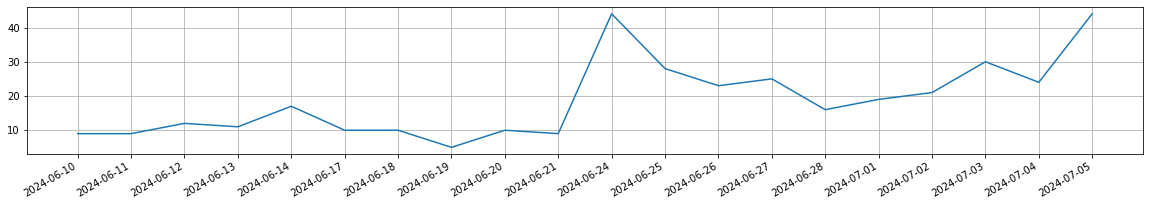

In [27]:
# gera_grafico(list_datas, d05_count)
gera_grafico(df_graficos['data'], df_graficos['qt_acoes_05'])

### Gráfico 10

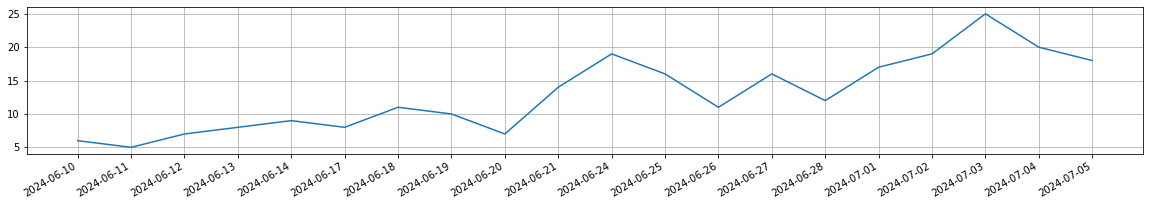

In [28]:
gera_grafico(df_graficos['data'], df_graficos['qt_acoes_10'])

### Gráfico 15

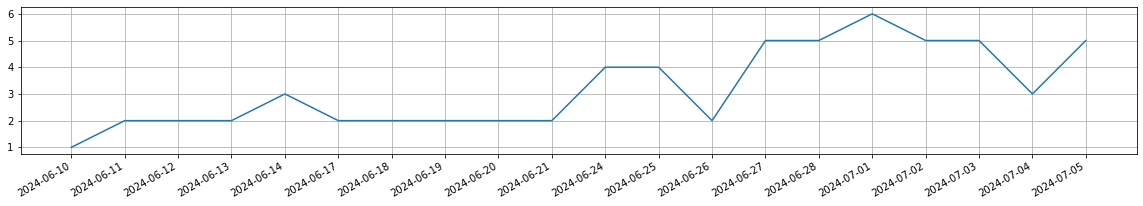

In [29]:
gera_grafico(df_graficos['data'], df_graficos['qt_acoes_15'])

### Gráfico 20

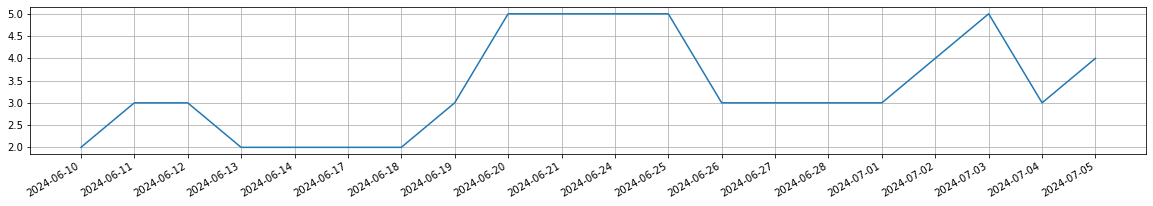

In [30]:
gera_grafico(df_graficos['data'], df_graficos['qt_acoes_20'])

### Gráfico 25

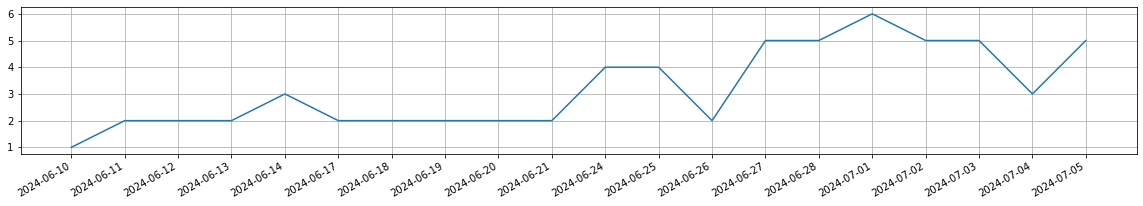

In [31]:
gera_grafico(df_graficos['data'], df_graficos['qt_acoes_25'])